In [2]:
import pandas as pd
import numpy as np
import factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("yinsu.csv") 
df.shape

(500, 5)

In [4]:
df.head()

,purchase_frequency,avg_spent,top_category,store_time,app_usage
0,6,264.693919,1,10.741316,2
1,6,154.865295,2,54.727444,2
2,5,212.729267,4,9.244390,4
3,5,270.765917,3,11.176717,5
4,4,85.332091,2,17.059377,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   purchase_frequency  500 non-null    int64  
 1   avg_spent           500 non-null    float64
 2   top_category        500 non-null    int64  
 3   store_time          500 non-null    float64
 4   app_usage           500 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 19.7 KB


这正是我们在这个项目中想要回答的这个业务问题。我重申，我不想做出预测。我不想预测购买偏好或平均支出。我可以，但那将是另一个项目。

我想要的是：查看这些历史数据，在购买时真正影响客户的是什么？ 是特定产品还是类别？如果客户在商店中花费更多时间，这是否表明他可能会进行购买，或者他只是在浏览？如果客户购买更多，花费更多，这是因素吗？换句话说，客户花费的金额是否是有助于解释购买行为的因素？我需要一个策略 — 我将应用因子分析。

我将降低维度，创建潜在因素，并解释它们。 基于此，我将准确回答业务问题。但要知道我是否可以应用因子分析，或者它是否适合这个数据集，我需要运行一些检查。所以现在，我将应用一些统计测试。我可以只应用一个选项，但我将借此机会向您展示两个选项，以确保我们是否可以在此数据集上使用因子分析。

使用 Bartlett 检验检查数据充分性：
计算 Bartlett 球形度检验的函数经常用于因子分析的上下文中，以检验球形度的假设——毫无疑问，这是一个花哨的名字。

如果数据是完美的球形，则意味着因子分析可能不合适，因为变量不相关。因此，要应用因子分析，变量之间需要存在相关性.

例如，这与我们使用回归时不同。在回归中，我们不需要多重共线性，即预测变量之间的相关性。这是我们在回归中要避免的事情。但这不是回归——这是因子分析。在这里，我想要变量之间的相关性，您必须小心这一点。

Bartlett 测试结果的解释：
与任何统计检验一样，您将获得检验统计量和 p 值。检验统计量量化数据与球度的差异程度。较高的值表示变量彼此之间具有显著的相关性，因此因子分析可能适用。因此，对于检验统计量，我需要尽可能高的值。

P 值：
与大多数统计检验一样，p 值有助于确定检验的显著性。较低的 p 值（通常小于 0.05（显著性水平））会拒绝球形度的零假设，这表明变量是相关的，因子分析可能合适。

较高的 p 值表明数据接近球形度，并且变量的相关性不强，这可能会使因子分析不太合适。

因此，我希望检验统计量具有尽可能高的值和尽可能低的 p 值，理想情况下低于 0.05。

总结：
要继续进行因子分析：

如果 p 值小于 0.05，则表示变量显著相关，因此适合进行因子分析。
如果 p 值大于 0.05，则在进行因子分析时需要谨慎。
问题是因子分析仍然有效，这就是解释变得至关重要的地方。您应用检验，解释结果，然后决定是否信任因子分析。就编程而言，它会奏效，但实际上是关于解释。

In [6]:
chi_square_value,p_value = calculate_bartlett_sphericity(df) 
print("Test Statistic:",chi_square_value,'\nP-value:',p_value)

Test Statistic: 2052.929448184787 
P-value: 0.0


那么，解释是什么呢？如果 p 值小于 0.05（我们的情况），则数据适合进行因子分析。这意味着变量之间存在相关性，这正是我们想要的。检验统计量的值很高，而 p 值很低 — 这正是我们正在寻找的。根据第一个测试，我们可以使用这些数据进行因子分析。

您可能会问：如果我没有通过第一次测试怎么办？ 假设 p 值大于 0.05。我该怎么办？ 好吧，您可以应用第二个测试进行确认，也可以立即放弃因子分析。

如果您未通过测试，则因子分析很可能不适合您的数据。从因子分析中得出的任何结论都可能是错误的。这就是测试的目的 — 确定是否使用因子分析。在我们的例子中，我们可以使用它。

使用 KMO 测试检查数据充分性
我们可以进一步确认我们是否可以使用 KMO 检验将这些数据用于因子分析，KMO 检验是因子分析充分性的另一种衡量标准。它还用于主成分分析 （PCA）.

KMO 检验评估可归因于潜在因素的观测变量之间的方差比例。这是您开始查看因子分析是否可用于提取潜在因子的地方。

KMO 度量的范围从 0 到 1。接近 1 的值表示与总相关性相比，变量之间的偏相关较小，这表明因子结构强大而清晰。

如果 KMO 值小于 0.5，则因子分析不合适，因此您可以将其删除。在 0.5 到 0.7 之间，它是平庸的。从 0.7 到 0.8，很好。从 0.8 到 0.9，这很棒。高于 0.9 时，效果很好.

In [7]:
kmo_all,kmo_model = calculate_kmo(df) 
print('Global KMO:',kmo_model)

Global KMO: 0.9119977905988941


统计测试失败
我们没有通过统计测试，这意味着我们不能使用因子分析。但我们仍然需要解决业务问题 - 那么我该如何告诉我的经理呢？问得好。事情是这样的：我们无法保证我们拥有的数据能够真正回答业务问题。

仅仅因为我们拥有数据并不意味着我们可以用它来解决问题。我们的分析可能会表明数据不适合此目的。我们正在进行分析，对吧？我们正在应用统计测试，结论可能很简单：有了这些数据，我们无法解决业务问题。

这可能不是每个人都在寻找的结论，但它是有效的。另一种选择是尝试不同的技术，例如 PCA。PCA 的问题在于它的可解释性较差。

因此，如果测试未通过，您有两个主要选择：要么尝试其他策略，例如 PCA，要么坦率地说：“我们不能使用这些数据;我们需要重新思考商业问题。也许我们只是无法从我们拥有的数据中获得所需的见解.

In [8]:
fa = FactorAnalyzer(rotation="varimax") 
fa.fit(df) 

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

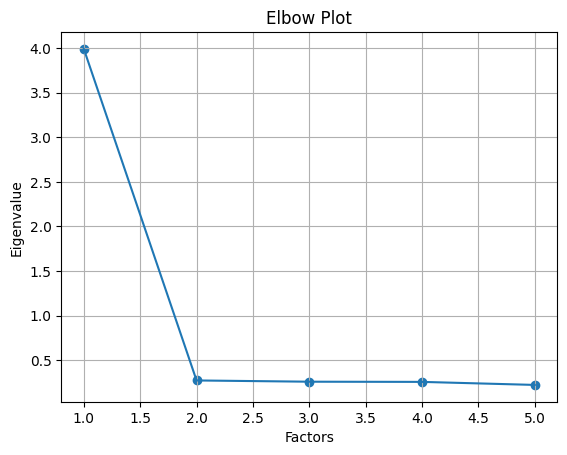

In [9]:
# 10. Checking the eigenvalues
eigen_values, vectors = fa.get_eigenvalues()
plt.scatter(range(1, df.shape[1] + 1), eigen_values)
plt.plot(range(1, df.shape[1] + 1), eigen_values)
plt.title('Elbow Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [10]:
import random
random.seed(1)

In [11]:
fa = FactorAnalyzer(n_factors=2, rotation="varimax")
fa.fit(df)

FactorAnalyzer(n_factors=2, rotation='varimax', rotation_kwargs={})

In [12]:
loadings = fa.loadings_
print(loadings)

[[0.77025527 0.3985401 ]
 [0.73479724 0.4260281 ]
 [0.53652225 0.84092422]
 [0.74905294 0.42623636]
 [0.7418765  0.44453942]]


In [13]:
fa.get_communalities()

array([0.7521274 , 0.72142692, 0.99500967, 0.74275775, 0.74799604])

拟合分析器 （fa.fit(df)） 后，您可以使用 fa.loadings_ 获得因子载荷。因子载荷表示每个变量与因子之间的线性关系。高载荷值（以绝对值表示）表示变量与因子密切相关。因子载荷的符号显示关系的方向。
您可以使用 fa.eigenvalues_ 检查特征值。这些也用于矩阵运算产生的主成分分析。它们表示每个因子解释的方差量。

这正是我们正在寻找的 — 了解每个因素解释的方差。我们有两个因素;每列代表一个。请注意，四个变量的方差由一个因子解释，而第五个变量的方差由另一个因子解释。

这种分离表明，四个变量具有相似的行为，表示一个潜在因子，一个变量是不同的，表示另一个潜在因子。很快，我们将对此进行总结，以提交给决策者。

通常，使用“Kaiser 准则”，其中只有特征值接近 1 的因子才被视为显著。但是，这只是一种启发式方法，可以使用其他技术，例如肘部图。

我已经使用了这种方法，这就是为什么我选择了两个因子 — 多亏了肘部的断裂，我现在可以充分解释两个因子的方差。特征值是矩阵运算的结果，它提供了这种见解。

3. 解释方差：

这表示由提取的因子解释的数据中总方差的比例。在因子分析中，我们通常会寻找一组较小的因子，这些因子仍然捕获总方差的很大一部分。

如果创建的因子过多，则方差会在它们之间分布较薄，从而更难找到潜在因子。这就是为什么最好使用较少的因素，就像我们在这里所做的那样。

4. 旋转：

旋转是一种用于使因子分析的输出更具可解释性的技术。Varimax 旋转尝试使因子载荷的方差最大化，使一些载荷尽可能接近 0，而使其他载荷尽可能接近 1 或 -1。这样可以更轻松地识别哪些变量与哪些因子相关联。

这就是为什么最后应用了旋转的原因，因为现在我有数字可以更轻松地解释结果。

5. 因素评分：

训练分析器后，您可以使用 fa.transform(df) 获取数据集中每个观测值的因子分数。因子分值表示每个观测值在每个因子上的分值。

6. 公社:

最后，可通过 fa.get_communalities() 访问的公因子方差表示由因子解释的每个变量中的方差比例。

In [14]:
loadings = fa.loadings_
print(loadings)

[[0.77025527 0.3985401 ]
 [0.73479724 0.4260281 ]
 [0.53652225 0.84092422]
 [0.74905294 0.42623636]
 [0.7418765  0.44453942]]


In [15]:
df.columns

Index(['purchase_frequency', 'avg_spent', 'top_category', 'store_time',
       'app_usage'],
      dtype='object')

因素 1 （F1）：按照变量的顺序，在购买频率、平均支出、存储时间和应用程序使用情况方面具有很强的负载。第一个变量（购买频率）在 F1 上的负载最高，表明它属于此因素，就像平均支出、商店时间和应用程序使用情况一样。这表明 F1 解释了这四个变量的方差，这些变量与整体客户参与度或他们与商店的关系强度有关。

这就是潜在因子：因子分析揭示的隐藏信息。它表明，提高客户参与度可以推动销售，而这种洞察力是分析性的，而不仅仅是猜测。F1 表示经常购买、消费一致的金额、在商店中停留的时间更长以及经常使用该应用程序的客户，这表明他们与商店有着密切的联系。

因子 2 （F2）：该因素对 top_category 具有非常强的因素负载，表明它可能与 “客户对产品类型或品牌的忠诚度” 有关。它可以代表正在寻找特定商品或品牌的买家，而不仅仅是关注商品的价格。

请记住，因素的解释不仅取决于载荷，还取决于业务环境和大量领域知识。上述解释严格基于我们模型中的因子载荷值，应根据有关客户和商店的其他信息进行调整。